## A Mathematical Approach to Map Matching Algorithms

### A project sponsered by Mitsubishi and supported by Tohoku University in Sendai, Japan

Team: Seiya Omura, Tomoya Akamatsu, Katelynn Huneycutt, Gabriel Gress


In [1]:
import networkx as nx
import osmnx as ox
import time
from shapely.geometry import Polygon, Point
import os, io, sys
import numpy as np
import ujson as json
import csv
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from algorithms import mm_utils
import fiona
from functools import reduce
from scipy.optimize import linprog
from scipy.sparse import csr_matrix
import dask

# Remove this when debugging
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
ox.__version__

#if not os.path.exists("temp/"):
#    os.makedirs("temp/")


'1.5.0'

### How do we represent road networks and GPS sequences computationally?

OpenStreetMaps is a tool to conveniently access map data anywhere in the world. For example, let's look at a map of Sendai.

Text(0.5, 1.0, 'Map of Sendai, Japan')

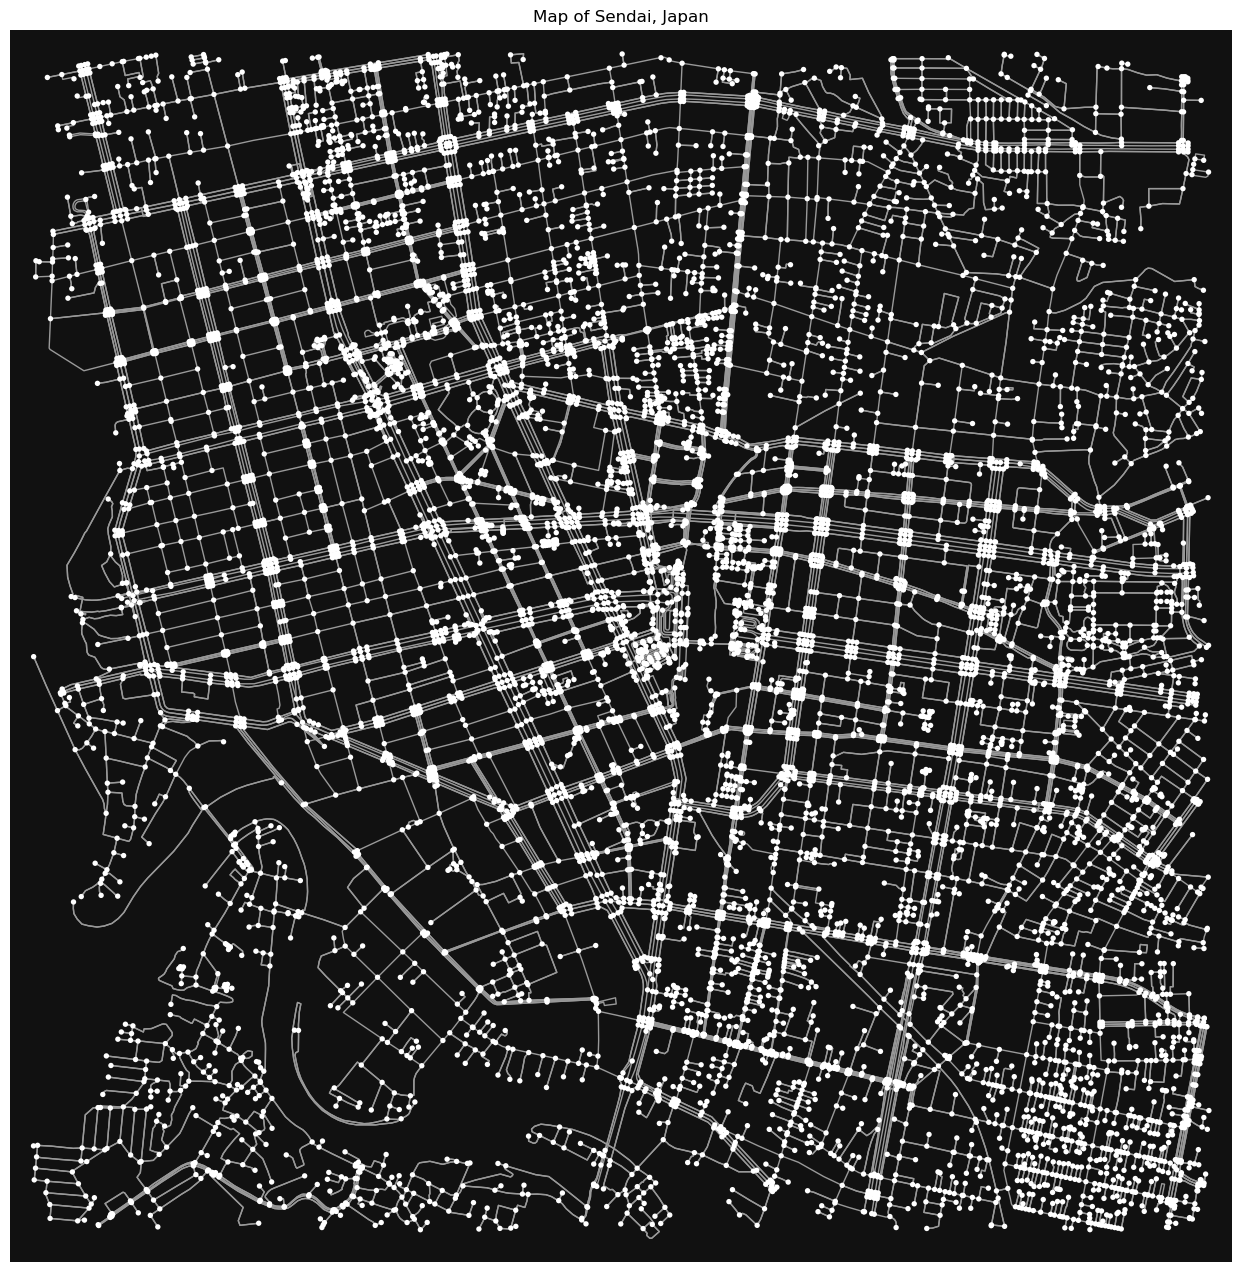

In [2]:
bignetwork = ox.graph_from_address(
"Sendai, Minamimachi-dori, Chuo 3-chome, Aoba Ward, Sendai, Miyagi Prefecture, 980-0021, Japan",
dist=1750, network_type='all')

fig, ax = ox.plot_graph(bignetwork, figsize = (16,16),show=False,close=False)

#campus = ox.geometries.geometries_from_place('Katahira Campus ',tags = {'name':True})
#campus.plot(ax=ax, alpha=0.5)

#gpd.GeoSeries([Point((140.87387,38.25448))]).plot(ax=ax, color='red')

ax.set_title('Map of Sendai, Japan')

#ax.legend(handles=[ax.collections[4],ax.collections[5]],
#          labels=['Tohoku University', 'Tokyo Electron House of Creativity'],
#          loc = 'lower right')

First, we download from OpenStreetMaps a street map for a section of Sendai, JP-- particularly, the area around Tohoku University.

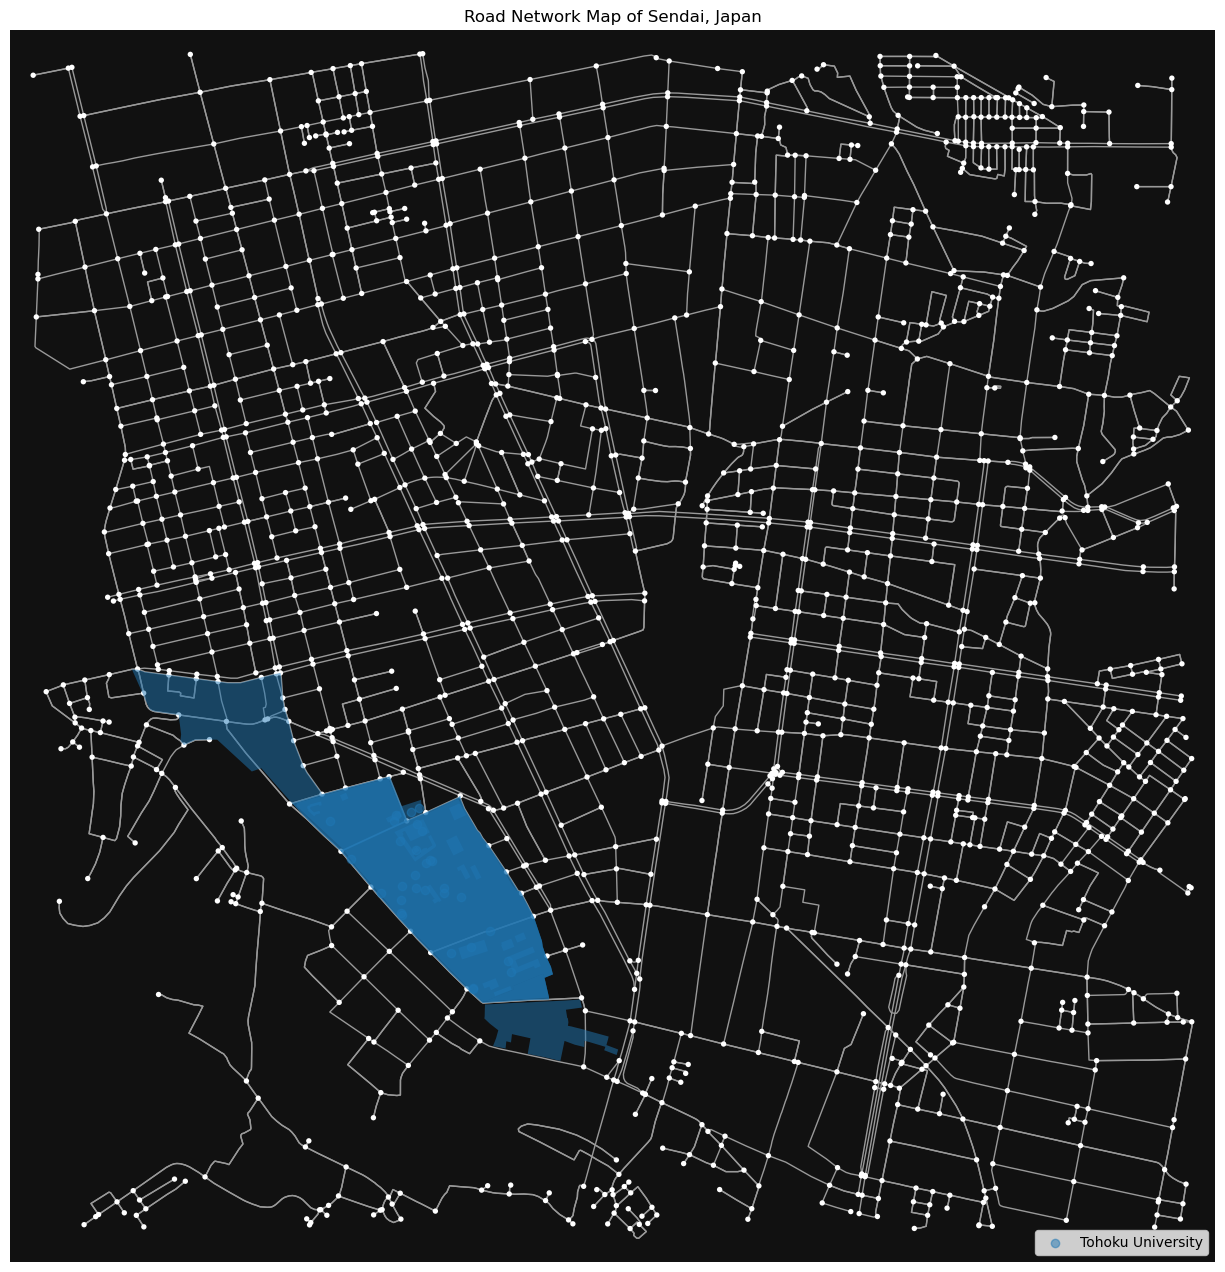

In [3]:
bignetwork = ox.graph_from_address(
"Sendai, Minamimachi-dori, Chuo 3-chome, Aoba Ward, Sendai, Miyagi Prefecture, 980-0021, Japan",
dist=1750, network_type='drive')

fig, ax = ox.plot_graph(bignetwork, figsize = (16,16),show=False,close=False)

campus = ox.geometries.geometries_from_place('Katahira Campus ',tags = {'name':True})
campus.plot(ax=ax, alpha=0.5)

# gpd.GeoSeries([Point((140.87387,38.25448))]).plot(ax=ax, color='red')

ax.set_title('Road Network Map of Sendai, Japan')

ax.legend(handles=[ax.collections[4]],
          labels=['Tohoku University'],
          loc = 'lower right')

The default format that OSMnx models networks is as `MultiDiGraph` objects. In order to manipulate these objects geometrically, we will need to convert this to `GeoDataFrame`. 

In [4]:
gdf_nodes, gdf_edges = ox.graph_to_gdfs(bignetwork)
#gdf_edges.dtypes
gdf_edges = gdf_edges.reset_index([0,1,2])
gdf_edges = gdf_edges.set_index('osmid')
gdf_nodes[['geometry']].head()

,geometry
osmid,
244879417,POINT (140.87168 38.26613)
244879418,POINT (140.87519 38.26009)
301789611,POINT (140.87349 38.25607)
301789634,POINT (140.87952 38.25282)
301789636,POINT (140.88325 38.25244)


In [5]:
gdf_edges[[ 'oneway', 'name', 'maxspeed', 'length', 'geometry']].head()

,oneway,name,maxspeed,length,geometry
osmid,,,,,
218028552,True,定禅寺通,60,17.586,"LINESTRING (140.87168 38.26613, 140.87148 38.2..."
461330966,True,東二番丁通,60,66.732,"LINESTRING (140.87168 38.26613, 140.87178 38.2..."
899682371,True,東二番丁通,60,95.226,"LINESTRING (140.87519 38.26009, 140.87565 38.2..."
1097371566,True,青葉通,NaN,16.784,"LINESTRING (140.87519 38.26009, 140.87500 38.2..."
837910375,False,NaN,NaN,11.727,"LINESTRING (140.87349 38.25607, 140.87347 38.2..."


Now let's look at the GPS data from a day walking around Sendai.

In [6]:
## We have some preprocessing to do first.

# Read the gpx directly
tripdata_nodes = gpd.read_file('Data/7-15-2022.gpx', layer = 'track_points')
    
# Read the IMU data directly
with open('Data/imu7-15-22 2_16_02.csv', mode = 'r') as f:
    tripdata_imu = csv.reader(f)
    tripdata_imu = pd.DataFrame(tripdata_imu)

# First we clean up the tripdata
tripdata_nodes = tripdata_nodes.dropna(axis=1, how = 'all')

# Let's convert the time into UNIX timestamps

from datetime import datetime as dt
import time

tripdata_nodes['time'] = (pd.to_datetime(tripdata_nodes['time']) - pd.Timestamp("1970-01-01").tz_localize("UTC")) // pd.Timedelta("1s")
tripdata_nodes = tripdata_nodes.rename(columns = {'time':'timestamp'})
tripdata_nodes = tripdata_nodes[['ele', 'timestamp', 'sat', 'geometry']]

# We will need the edges for FMM, so I wrote a helper function to create edges from points
tripdata_edges = mm_utils.point_to_traj(tripdata_nodes, columns = {'ele': 'average',
                                                                  'timestamp':'first',
                                                                  'sat':'first'})

# Now lets work on the IMU data.

tripdata_imu[0] = tripdata_imu[0].astype(float)

accel = []
for i in range(len(tripdata_imu)):
    row = tripdata_imu[[2,3,4]].loc[0]
    accel.append((float(tripdata_imu[[2,3,4]].loc[i].iloc[0]),
                  float(tripdata_imu[[2,3,4]].loc[i].iloc[1]),
                  float(tripdata_imu[[2,3,4]].loc[i].iloc[2])))

    
#tripdata_imu = tripdata_imu.rename(columns = {'0':'timestamp', '})

# We need to convert the times to UNIX timestamps.
    
timediff = dt.strptime('2022-07-15T02:16:02', '%Y-%m-%dT%H:%M:%S').timestamp() - float(tripdata_imu[0][0])

# Not going to overwrite tripdata_imu yet because we haven't done gyro yet
newdf = pd.DataFrame({'timestamp': tripdata_imu[0] + timediff, 'accelerometer' : accel,})

# We will separate the gyroscope data for later because it isn't synchronous with the rest of the data
# We will simply fuse this at the end

gyro = []
gyrotime = []

for i in range(len(tripdata_imu)):
    if tripdata_imu[5].loc[i] is not None:
        if float(tripdata_imu[5].loc[i]) == 4:
            gyrotime.append(float(newdf['timestamp'].loc[i]))
            gyro.append((float(tripdata_imu[[6,7,8]].loc[i].iloc[0]),
                      float(tripdata_imu[[6,7,8]].loc[i].iloc[1]),
                      float(tripdata_imu[[6,7,8]].loc[i].iloc[2])))

tripdata_gyro = pd.DataFrame({'timestamp':gyrotime, 'gyroscope':gyro})

tripdata_imu = newdf


Now let's fuse!

In [7]:
tripdata_nodes = mm_utils.fuse(mm_utils.fuse(tripdata_nodes, tripdata_imu, 'timestamp', 'nearest neighbor'), tripdata_gyro, 'timestamp', 'nearest neighbor')

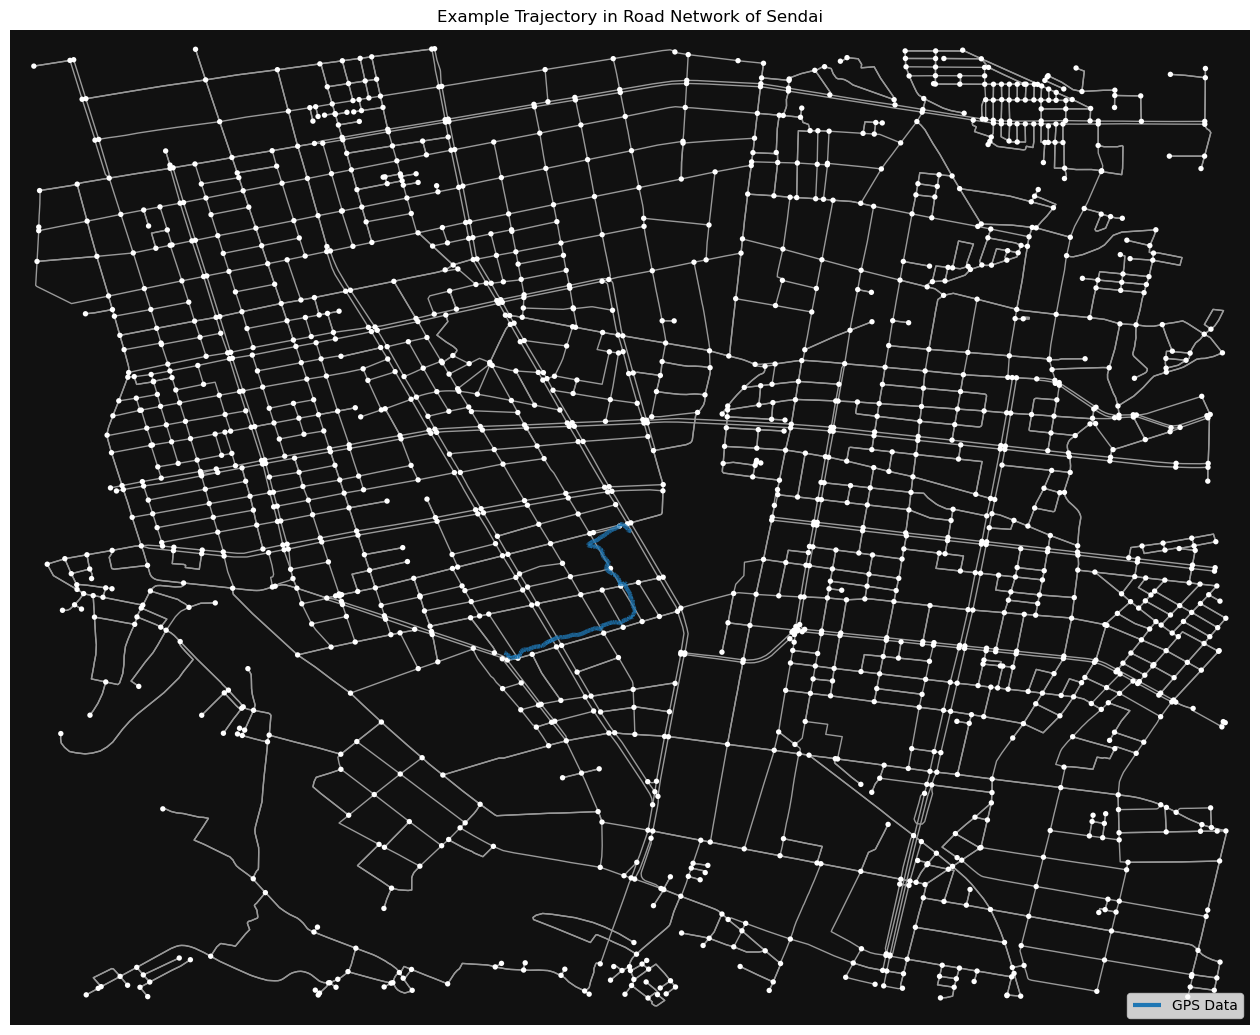

In [8]:
fig, ax = ox.plot_graph(bignetwork, figsize = (16,16),show=False, close=False)
#tripdata_nodes.plot(ax=ax)
tripdata_edges.plot(ax=ax, linewidth=3)
ax.set_title('Example Trajectory in Road Network of Sendai')
ax.legend(handles=[ax.collections[2]],labels=['GPS Data'], loc = 'lower right')

Let's zoom in a bit.

(645, 6)


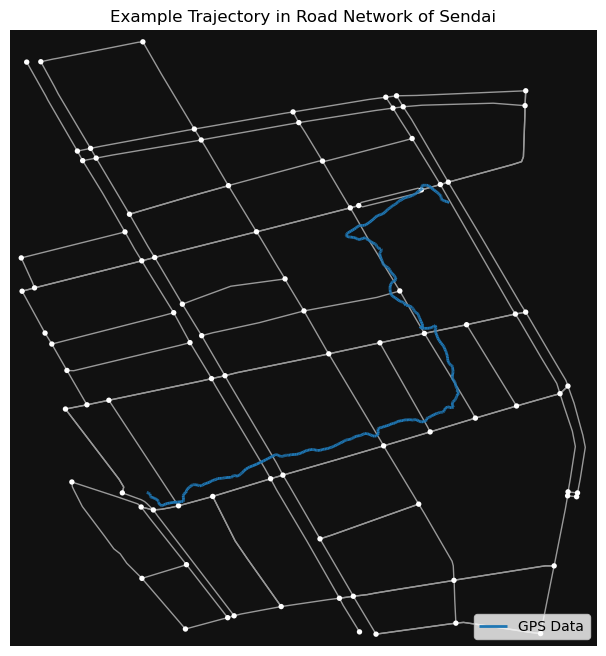

In [9]:

smallnetwork = mm_utils.df_to_network(tripdata_nodes, as_gdf = False)
fig, ax = ox.plot_graph(smallnetwork, figsize=(16,8), show=False, close=False)
tripdata_edges.plot(ax=ax, linewidth=2)
#tripdata_nodes.plot(ax=ax, markersize=1) # Don't really need to plot this, there's so many nodes that it looks identical to the edges
print(tripdata_nodes.shape)
ax.set_title('Example Trajectory in Road Network of Sendai')
ax.legend(handles=[ax.collections[2]],labels=['GPS Data'], loc = 'lower right')

Now we will run this information through FMM.

In [10]:
# The Python module for FMM is broken due to dependency errors. The only workaround is to use Docker, which is how I obtained these results. This is not easily made compatible with Python, so this cell is disabled


# FMM OUTPUT:

# fmm --ubodt ubodt_table.csv --network_id fid --source u --target v --network edges.shp --gps tripdata.shp --gps_id FID --output fmm_output
# [info][fmm_app_config.cpp:49 ] Start reading FMM configuration from arguments
# [info][fmm_app_config.cpp:78 ] Finish with reading FMM arg configuration
# [info][fmm_app_config.cpp:98 ] ----   Print configuration    ----
# [info][network_config.cpp:6  ] NetworkConfig
# [info][network_config.cpp:7  ] File name: edges.shp 
# [info][network_config.cpp:8  ] ID name: fid 
# [info][network_config.cpp:9  ] Source name: u 
# [info][network_config.cpp:10 ] Target name: v 
# [info][gps_config.cpp:8  ] GPS format: GDAL trajectory
# [info][gps_config.cpp:9  ] File name: tripdata.shp 
# [info][gps_config.cpp:10 ] ID name: FID 
# [info][gps_config.cpp:11 ] Timestamp name: timestamp 
# [info][result_config.cpp:34 ] ResultConfig
# [info][result_config.cpp:35 ] File: fmm_output
# [info][result_config.cpp:36 ] Fields: cpath mgeom 
# [info][fmm_algorithm.cpp:27 ] FMMAlgorithmConfig
# [info][fmm_algorithm.cpp:29 ] k 8 radius 300 gps_error 50 reverse_tolerance 0
# [info][fmm_app_config.cpp:103] Log level 2-info
# [info][fmm_app_config.cpp:104] Step 100
# [info][fmm_app_config.cpp:105] Use omp false
# [info][fmm_app_config.cpp:106] ---- Print configuration done ----
# [info][network.cpp:72 ] Read network from file edges.shp
# [info][network.cpp:170] Number of edges 3949 nodes 1691
# [info][network.cpp:172] Field index: id 14 source 0 target 1
# [info][network.cpp:174] Read network done.
# [info][network_graph.cpp:17 ] Construct graph from network edges start
# [info][network_graph.cpp:30 ] Graph nodes 1691 edges 3949
# [info][network_graph.cpp:31 ] Construct graph from network edges end
# [info][ubodt.cpp:208] Reading UBODT file (CSV format) from ubodt_table.csv
# [info][ubodt.cpp:236] Read rows 1000000
# [info][ubodt.cpp:236] Read rows 2000000
# [info][ubodt.cpp:243] Finish reading UBODT with rows 2829140
# [info][ubodt.cpp:202] Read UBODT file in 2.569 seconds
# [info][gps_reader.cpp:337] GPS data in trajectory shapefile format
# [info][gps_reader.cpp:45 ] Read trajectory from file tripdata.shp
# [warning][gps_reader.cpp:69 ] Timestamp column timestamp not found
# [info][gps_reader.cpp:81 ] Total number of trajectories 644
# [info][gps_reader.cpp:82 ] Finish reading meta data
# [info][fmm_app.cpp:27 ] Progress report step 100
# [info][fmm_app.cpp:29 ] Start to match trajectories
# [info][fmm_app.cpp:58 ] Run map matching in single thread
# [info][fmm_app.cpp:61 ] Progress 0
# [info][fmm_app.cpp:61 ] Progress 100
# [info][fmm_app.cpp:61 ] Progress 200
# [info][fmm_app.cpp:61 ] Progress 300
# [info][fmm_app.cpp:61 ] Progress 400
# [info][fmm_app.cpp:61 ] Progress 500
# [info][fmm_app.cpp:61 ] Progress 600
# [info][fmm_app.cpp:75 ] MM process finished
# [info][fmm_app.cpp:79 ] Time takes 0.844
# [info][fmm_app.cpp:80 ] Time takes excluding input 0.844
# [info][fmm_app.cpp:82 ] Finish map match total points 1288 matched 1288
# [info][fmm_app.cpp:83 ] Matched percentage: 1
# [info][fmm_app.cpp:84 ] Point match speed: 1526.07
# [info][fmm_app.cpp:86 ] Point match speed (excluding input): 1526.07
# [info][fmm_app.cpp:87 ] Time takes 0.844

network_edges = gpd.read_file('fmm_runtime_files/Tohoku/edges.shp')
# set network_edges.fid = network_edges.FID
#setattr(network_edges, 'fid', network_edges.FID)
network_edges.fid = network_edges.fid.astype(int)

def extract_cpath(cpath):
        if (cpath==''):
            return []
        elif type(cpath) == float:
            if math.isnan(float(cpath)):
                return []
            else:
                return [int(cpath)]
        else:
            return [int(s) for s in cpath.split(',')]

# fmm_results = gpd.read_file('Data/fmm_output.csv')
fmm_results = gpd.read_file('fmm_runtime_files/fmm_output.csv')

fmm_results['cpath_list'] = fmm_results.apply(lambda row: extract_cpath(row.cpath), axis=1)

edge_ids = np.unique(np.hstack(fmm_results.cpath_list)).tolist()

edges_df = network_edges[network_edges.fid.isin(edge_ids)].reset_index()

# mm_utils.plot(network = smallnetwork, input_data = tripdata_edges, results = fmm_results, fs = (16,16))
# plt.gca().legend(handles=[plt.gca().collections[2],plt.gca().collections[3]],labels=['Trip around Sendai','FMM Predicted Route'], loc = 'lower right')
# plt.gca().set_title('FMM Prediction')


In [11]:
%%time

#from algorithms import fmm_bin # FMM broke AGAIN. Not fixing it this time.
#from fmm import FastMapMatchConfig
### Define map matching configurations

k = 16
radius = 0.003
gps_error = 0.0005

# create a text trap and redirect stdout
#text_trap = io.StringIO()
#sys.stdout = text_trap

#fmm_config = FastMapMatchConfig(k,radius,gps_error)
cfg_file = None



#fmm_sim = fmm_bin.FMM(cfg = fmm_config)

#fmm_sim.run(tripdata_edges)

# now restore stdout function
#sys.stdout = sys.__stdout__

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.58 µs


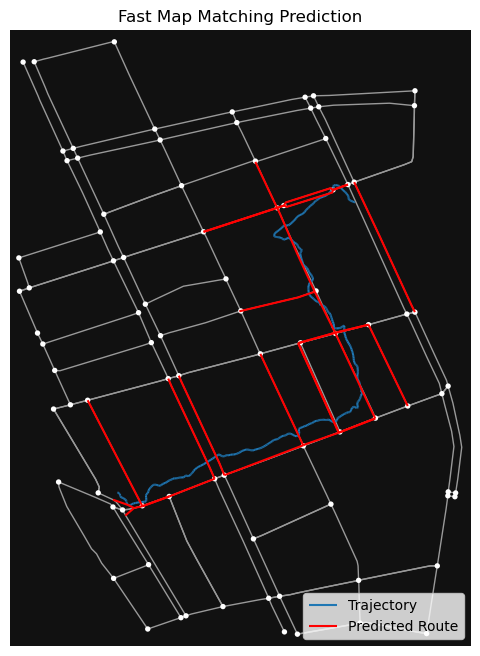

In [12]:

mm_utils.plot(network = smallnetwork, input_data = tripdata_edges, results = edges_df, fs = (16,8))
plt.gca().legend(handles=[plt.gca().collections[2],plt.gca().collections[3]],labels=['Trajectory','Predicted Route'], loc = 'lower right')
plt.gca().set_title('Fast Map Matching Prediction')
plt.show();

This is pretty bad. The issue is that FMM (and other Hidden Markov Model approaches) do not perform well with an overabundance of data. Even small deviations with lots of datapoints dominate, and the algorithm tries to match it to roads it shouldn't.

This is where a geometric method performs better. If we work with nodes, these small deviations do not affect the loss much on average, so they are effectively ignored. If we work with a polyline, then the amount of nodes becomes entirely irrelevant, and so geometric methods are far more flexible when datapoint quantity may vary.

In [13]:
from algorithms import metric_mm

### Define map matching configurations

## Least squares functions
ls_ri = lambda distarray: np.square(distarray) # The function applied directly to the distances from the candidate route to the k-NN GPS coords
ls_ro = lambda distarray: 1*(1/np.size(distarray) * np.sum(distarray)) # This is where we 'integrate' over the distances, and if we need to do anything else, we do it
ls_gi = lambda distarray: np.square(distarray) # The function applied directly to the distances from the GPS coords to the k-NN candidate route nodes
ls_go = lambda distarray: 1*(1/np.size(distarray) * np.sum(distarray))
##

## Inverse squares function ('Electrical method')
eps = 0.01
is_ri = lambda distarray: np.power(np.square(distarray) + eps, -1) # We need eps to prevent singularities, i.e. r = 0
is_ro = lambda distarray: -1*(1/np.size(distarray) * np.sum(distarray)) # We sum, and then multiply by -1 to turn the minimizing process into a maximizing process
is_gi = lambda distarray: np.power(np.square(distarray) + eps, -1)
is_go = lambda distarray: -1*(1/np.size(distarray) * np.sum(distarray))
##

def wrapper_f(ri, ro, gi, go): # This should return a function composed from the basic functions, that can then be applied onto route and gps data.
    return lambda route, gps : 1*ro(ri(route)) + 1*go(gi(gps))

ls_loss_function = wrapper_f(ls_ri, ls_ro, ls_gi, ls_go)
is_loss_function = wrapper_f(is_ri, is_ro, is_gi, is_go)

def wasserstein(routeloss, gpsloss):#gpsloss,n,m
    #the (i,j)th entry of the gpsloss matrix is the distance from the ith point of the trajectory to the jth point on the candiate route
    # n is the number of points along the trajectory
    # m is the number of points on the candidate route
#    print(gpsloss.shape)
    n = gpsloss.shape[0]
    m = gpsloss.shape[1]
    #the (i,j)th entry of the gpsloss matrix is the distance from the ith point of the trajectory to the jth point on the candiate route
    #Create equality constraints
    b = [1/n for i in range(0,n)]+ [1/m for i in range(0,m)]
    row1 = [i for i in range(0,n) for j in range(0,m)]
    row2 = [n+j for j in range (0,m) for i in range(0,n)]
    row = np.append(np.matrix.flatten(np.array(row1)),np.matrix.flatten(np.array(row2)))
    col1 = [list(range(0,n*m))]
    col2 =  [j+m*k for j in range(0,m) for k in range(0,n)]
    col = np.append(np.matrix.flatten(np.array(col1)),np.matrix.flatten(np.array(col2)))
    data = np.ones(n*m*2)
    A = csr_matrix((data, (row, col)),shape = (n+m, n*m)).toarray()
    A = A[:-1]
    b = b[:-1]
    #solve the linear program
    res = linprog(np.matrix.flatten(gpsloss),None, None,A,b)
    #return the function value, i.e. the wasserstein distance
    loss = res.fun
    return loss

In [14]:
sim4 = metric_mm.Sim(loss_function = wasserstein)

In [15]:
%%time

print('Obtaining Candidate Routes')

# "Joints" in polylines should not be included as the candidates of nearest points from trajectory points.
qry_pts = [y for sublist in [(edge.coords[:][0], edge.coords[:][-1]) for edge in gdf_edges['geometry']] for y in sublist]
# Points near trajectory points
source_index, _ = mm_utils.get_nearest([(tripdata_nodes['geometry'].iloc[0].x, tripdata_nodes['geometry'].iloc[0].y)], qry_pts, k_neighbors = 1)
source_index = source_index[0][0]
target_index, _ = mm_utils.get_nearest([(tripdata_nodes['geometry'].iloc[-1].x, tripdata_nodes['geometry'].iloc[-1].y)], qry_pts, k_neighbors = 1)
target_index = target_index[0][0]

# print(len(qry_pts))
# print(source_index)
# print(target_index)

source = Point(qry_pts[source_index])
target = Point(qry_pts[target_index])

# print('source', source)
# print('target', target)

# Edges near trajectory points
candidates = mm_utils.get_nearest_edges(tripdata_nodes, gdf_edges, k_neighbors=8, r = 0.01) # If r is too large it will run slow, as getting nearest edges is computationally difficult
all_candidate_edges = reduce(lambda left,right: pd.concat([left, right]).drop_duplicates(subset=['geometry']), candidates)
candidate_routes, _ = mm_utils.dijkstra(source, target, all_candidate_edges, one_way = False)
    # I recommend starting with small values that yield less than k k_neighbors, and slowly increase from there
# The one_way = False parameter is VERY important here.
# Road networks are given as collections of one-way streets.
# In Sendai, many small roads are one-way, and so the algorithm will assume you cannot traverse them in reverse
# In our case though, we are walking, so we can ignore one-way streets
# If you do not include this parameter, the route taken is not considered valid, and so is not considered at all.

Obtaining Candidate Routes
CPU times: user 22.6 s, sys: 90.4 ms, total: 22.7 s
Wall time: 22.7 s


In [16]:
%%time

print('Preprocessing Candidate Routes')

sim2 = metric_mm.Sim(ls_ri, ls_ro, ls_gi, ls_go, wrapper_f) # Least squares metric-based
sim2.preprocessing(tripdata_edges, candidate_routes = candidate_routes, n = 1)




Preprocessing Candidate Routes
CPU times: user 5.71 s, sys: 30.2 ms, total: 5.74 s
Wall time: 5.74 s


In [17]:
%%time

print('Least Squares Runtime')

sim2_results = sim2.run(k1 = 10, k2 = 10, return_results = True, parallel = True)[0]


Least Squares Runtime
CPU times: user 655 ms, sys: 9.79 ms, total: 665 ms
Wall time: 663 ms


In [18]:
%%time

print('Inverse Squares Runtime')

sim3 = metric_mm.Sim(loss_function = is_loss_function,
                     trajectory = sim2.trajectory,
                     candidate_route_nodes = sim2.candidate_route_nodes,
                     candidate_routes = sim2.candidate_routes)
sim3_results = sim3.run(k1 = -1, k2 = -1, return_results = True, parallel = True)[0]


Inverse Squares Runtime
CPU times: user 6.19 s, sys: 232 ms, total: 6.42 s
Wall time: 4.42 s


In [19]:
%%time

print('Wasserstein Runtime')
loss = []
sim4.preprocessing(tripdata_edges, candidate_routes = candidate_routes,n=1,m=1)

Wasserstein Runtime
CPU times: user 5.07 s, sys: 49.7 ms, total: 5.12 s
Wall time: 5.13 s


In [20]:
%%time

sim4_results = sim4.run(k1 = 0, k2 = -1, return_results = True, parallel = True)[0]

CPU times: user 5.23 s, sys: 1.66 s, total: 6.89 s
Wall time: 2.34 s


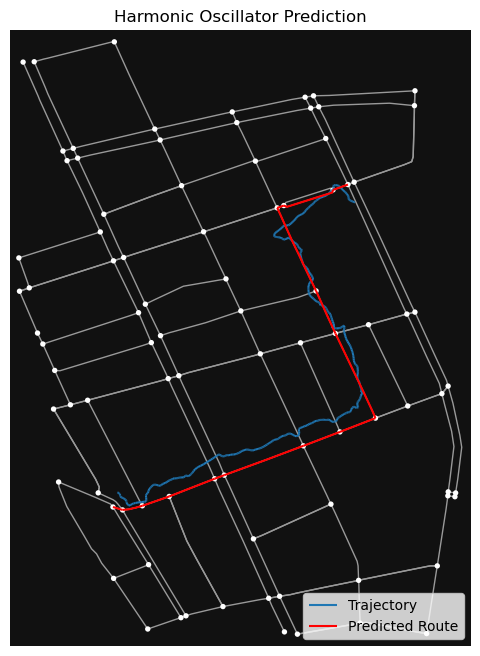

In [21]:

mm_utils.plot(network = smallnetwork, input_data = tripdata_edges, results = sim2_results, fs = (16,8))
plt.gca().legend(handles=[plt.gca().collections[2],plt.gca().collections[3]],labels=['Trajectory','Predicted Route'], loc = 'lower right')
plt.gca().set_title('Harmonic Oscillator Prediction')
plt.show();

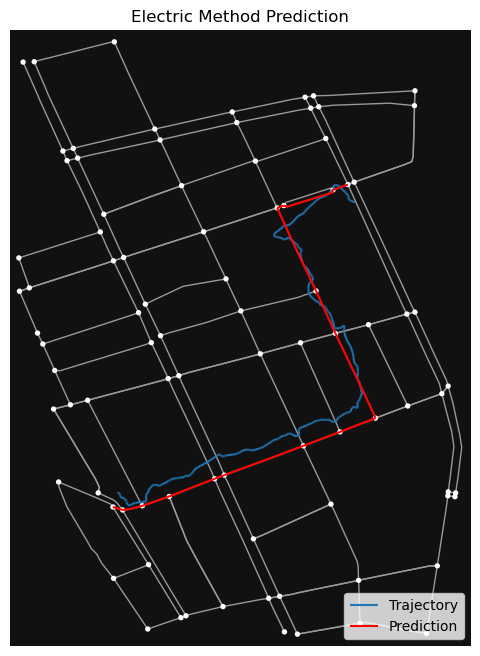

In [22]:
mm_utils.plot(network = smallnetwork, input_data = tripdata_edges, results = sim3_results, fs = (16,8))
plt.gca().legend(handles=[plt.gca().collections[2],plt.gca().collections[3]],labels=['Trajectory','Prediction'], loc = 'lower right')
plt.gca().set_title('Electric Method Prediction')
plt.show();

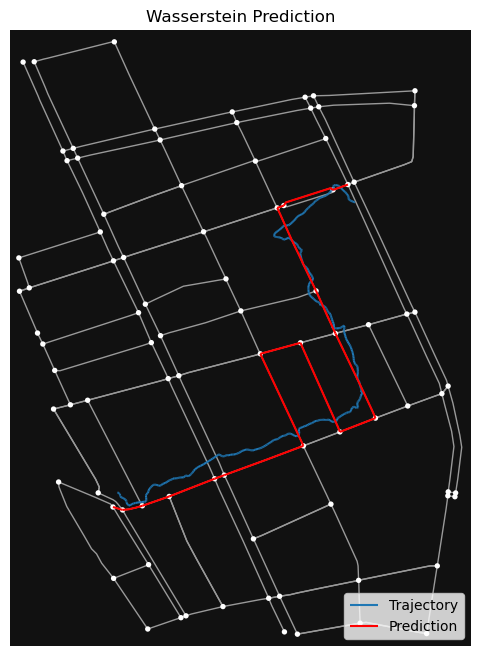

SUCCESS!!!


In [23]:

mm_utils.plot(network = smallnetwork, input_data = tripdata_edges, results = sim4_results, fs = (16,8))
plt.gca().legend(handles=[plt.gca().collections[2],plt.gca().collections[3]],labels=['Trajectory','Prediction'], loc = 'lower right')
plt.gca().set_title('Wasserstein Prediction')
plt.show();

print("SUCCESS!!!")